In [5]:
import os
import sys
#os.environ['http_proxy'] = ""
#os.environ['https_proxy'] = ""

#### Helper functions to visualize data (execute these cells)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_segment(original_data, segmented_data, segment_id=0, axis=['gyroy'], ylim=(-2000,2000)):
    if segment_id not in segmented_data.SegmentID.unique():
        print "segment id", segment_id, "not in segmented data"
        return 
    seg_start, seg_end = segmented_data[segmented_data.SegmentID==segment_id].iloc[0][['Seg_Begin','Seg_End']].values
    if seg_start >= 10:
        delta_start = 10
    else:
        delta_start = 0
        
    original_data[axis].iloc[seg_start-delta_start:seg_end+10].plot(figsize=(16,6), lw=2)
    seg_start = [seg_start,seg_start]
    seg_end = [seg_end,seg_end]
    plt.plot(seg_start, [-max(ylim), max(ylim)],'g',lw=3)
    plt.plot(seg_end, [-max(ylim), max(ylim)],'r',lw=3)
    plt.ylim(ylim[0], ylim[1])

In [7]:
def plot_segmented_data_stream(original_data, segmented_data, axis, ylim=(-5000,5000)):
    if axis not in segmented_data.columns:
        print "column {} is not in your dataframe.".format(axis)
    if 'Seg_Begin' not in segmented_data.columns or 'Seg_End' not in segmented_data.columns:
        print 'Segmented data does not contain seg start or end, make sure to set "segment_index":True in your segmentation parameters.'
    original_data[[axis]].plot(figsize=(16,3))
    for seg in segmented_data.Seg_Begin.unique():
        plt.plot([seg,seg], [-max(ylim), max(ylim)], 'g', lw=4)
    for seg in segmented_data.Seg_End.unique():
        plt.plot([seg,seg], [-max(ylim), max(ylim)], 'r', lw=4)
    plt.ylim(ylim[0], ylim[1]) 

# Segmention of Data

In order to build a model with your data you need to be able to break down the incoming signal into segments which can be represented as a feature vector. Selecting the correct segmentation algorithm can be one of the more challenging parts of building a successful pipeline. The trick is to capture segments that contain enough information about the class that you want to recognize while balancing the need to optimize for real-time analytics.

The most basic example of a segmenter is a sliding window. The sliding window is a "naive" segmenter, in that it doesn't need to know anything about the signal to create a segment. It works by creating a buffer of, say window size 250 data points, and passes that segment to the next steps in your pipeline. Then the window slides a certain distance, such as delta=100, and passes another segment along the pipeline. For certain types of classification, this is all you will need. 

However, in many cases you will need more sophisticated segmentation algorithms. For example, instead of passing every segment to your pipeline and eating up battery doing unnecessary calculations you may want to filter out segments that don't contain useful information. Alternatively, if you are classifying events that occur infrequently, you may want to use a segmenter that only activates when that event occurs so that you can be sure to catch the beginning of the event. 

Knowledgebuilder has segmentation algorithms to help in optimizing your pipeline to select the event areas of a signal. They can be broken down into 3 different categories, filter based, threshold based and key based. In this tutorial we will walk through the different types of segmentation that you can perform.


### 1.  Filter Based

Filter based segmenters use a sliding window and either reject or accept the segments based on certain criteria. 

### 2. Threshold based

These are segmenters that help to identify the start of unique signals. They identify when the signal passes a certain threshold before setting the segment start. After that threshold is passed, a segment of the specified length is created. 

### 3.  Key Based

Key segmentation are segmenters that identify segments based on particular actions. These are similar to key words used in products like saying "OK google" to start a query in google now. They are highly customized algorithms that have been tailored to specific use cases. 

In [8]:
from sensiml import SensiML
import pandas as pd 

dsk = SensiML()
dsk.project =  'Segmentation'
dsk.pipeline = 'tutorial_6_segmentation_pipeline'

In [9]:
sensor_columns = ['AccelerometerX','AccelerometerY','AccelerometerZ']
data = pd.read_csv('Support/segment_data/pause_detection_data.csv').iloc[:5000]
data = data.drop(['Unnamed: 0'], axis =1)

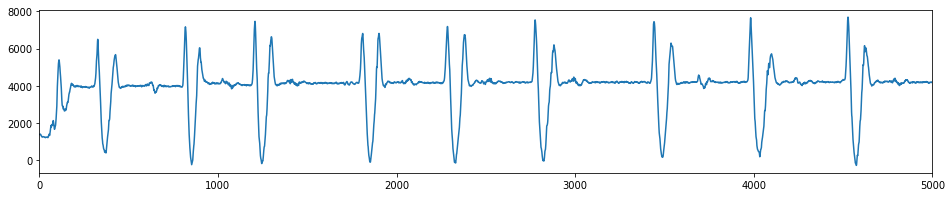

In [10]:
data.AccelerometerZ.plot(figsize=(16,3))

## Sliding Window

In [11]:
dsk.pipeline.reset()
dsk.pipeline.set_input_data('pause_gesture.csv', data, group_columns=['Subject'], force=True)
dsk.pipeline.add_transform('Windowing', params={'window_size':100, 'delta':115,'return_segment_index':True})
segmented_data, stats = dsk.pipeline.execute()

Uploading file "pause_gesture.csv" to KB Cloud.
Upload of file "pause_gesture.csv"  to KB Cloud completed.
Label Column must be a string
Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: pause_gesture.csv         		Type: featurefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for Results:

Retrieving page 1 of 1.

Results Retrieved.


make a plot of all the segmented data, green is start of segment, red is the end of the segment. 

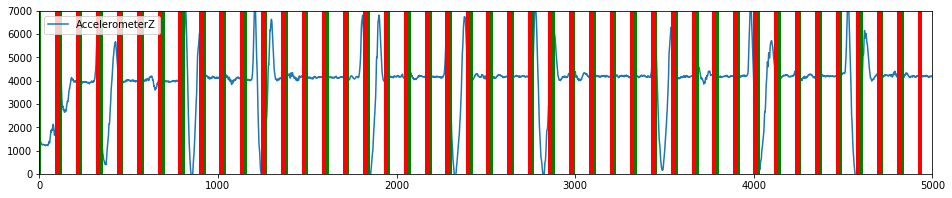

In [12]:
plot_segmented_data_stream(data, segmented_data, 'AccelerometerZ', ylim=(0,7000))

make a plot of a single segment

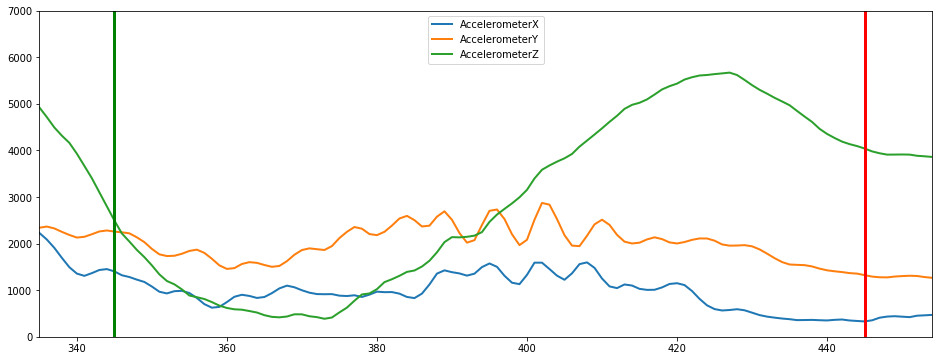

In [13]:
plot_segment(data, segmented_data, segment_id=3, axis=['AccelerometerX','AccelerometerY','AccelerometerZ'], ylim=(0,7000))

## Filter Based Segmentation

Windowing can be used on its own or with a filter. For this example we will window the data to a window_size of 100 and put our delta to 115. Typically delta is smaller than or equal to the window size, but I'm increasing it to aid in the visualization.

In [14]:
dsk.pipeline.reset()
dsk.pipeline.set_input_data('pause_gesture.csv', data, group_columns=['Subject'], force=True)
dsk.pipeline.add_transform('Windowing', params={'window_size':50, 'delta':65,'return_segment_index':True})
#dsk.pipeline.add_transform('Scale Factor', params={'scale_factor':4096., 'input_columns':['AccelerometerX','AccelerometerY','AccelerometerZ']})
dsk.pipeline.add_transform("MSE Filter", params={"input_column": 'AccelerometerX', 
							"MSE_target":-1.0,
							"MSE_threshold":250000.0})
segmented_data, stats = dsk.pipeline.execute()

Uploading file "pause_gesture.csv" to KB Cloud.
Upload of file "pause_gesture.csv"  to KB Cloud completed.
Label Column must be a string
Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: pause_gesture.csv         		Type: featurefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: MSE Filter                		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for Results:

Retrieving page 1 of 1.

Results Retrieved.


make a plot of all the segmented data, green is start of segment, red is the end of the segment. As you can see segments have been filtered out which fall below the threshold. Typically the windowing segmentation algorithm is best for building models with periodic data. The data presented in this example would not create a great model, as you can see the signal here has been broken up into multiple segments. Ideally, the entire event should be captured in a single segment. The next segmenter we show in this tutorial is designed to capture single events. 

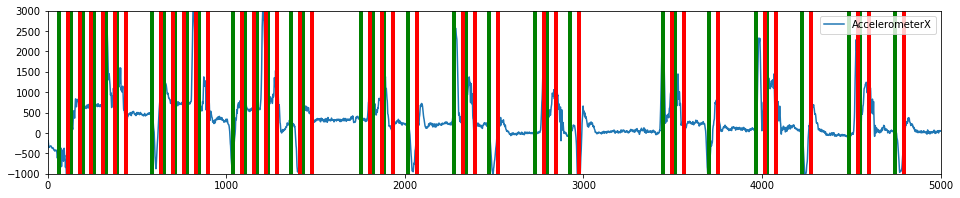

In [15]:
plot_segmented_data_stream(data, segmented_data, 'AccelerometerX', ylim=(-1000,3000))

## Threshold Based Segmentation


### General Threshold Algorithm

The general threshold algorithm is a customizable threshold algorithm that allows you to flexibly specify many of the parameters. In technical terms we compute a threshold space use a sliding window on the axis you choose transforming the original timeseries domain into one of the following (standard deviation, absolute sum, sum, variance, absolute average). This is a general algorithm than can be tuned to suit a variety of applications, particularly in cases where events are well separated in time domain. 

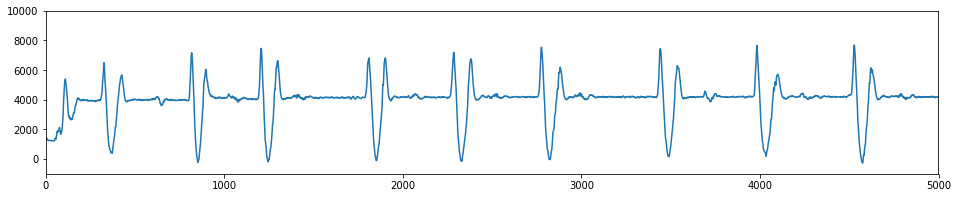

In [16]:
data.AccelerometerZ.plot(figsize=(16,3), ylim=(-1000,10000))

In [17]:
dsk.pipeline.reset()
dsk.pipeline.set_input_data('pause_gesture.csv', group_columns=['Subject'])

Label Column must be a string


Add the Pause-Peak Algorithm to the segmantation pipeline 

In [18]:
#Applying windowing thresholding
dsk.pipeline.add_transform('General Threshold Segmentation', params={'first_column_of_interest': 'AccelerometerZ',
                                                                     'second_column_of_interest': 'AccelerometerZ',
                                                                     'max_segment_length':225,
                                                                     'min_segment_length':125,
                                                                     'first_vt_threshold':600., 
                                                                     'second_vt_threshold':150.,
                                                                     'first_comparison':'max',
                                                                     'second_comparison':'min',
                                                                     'threshold_space_width':25,
                                                                     'first_threshold_space':'std',
                                                                     'second_threshold_space':'std',
                                                                     'return_segment_index':True
                                               }
                          )

segmented_data, stats = dsk.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: pause_gesture.csv         		Type: featurefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: General Threshold Segmentation 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for Results:

Retrieving page 1 of 1.

Results Retrieved.


As you can see multiple segments were recognized. The green is the start of a segment and the red is the end of the segment. 

column AccelerometerZ is not in your dataframe.


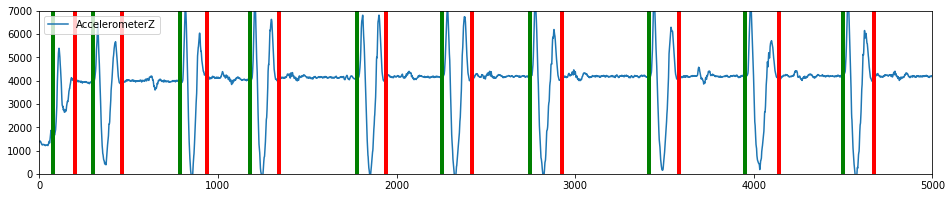

In [19]:
plot_segmented_data_stream(data, segmented_data, 'AccelerometerZ', ylim=(0,7000))

the following plot allows you to look at individual segments and see multiple data streams from the original data. 

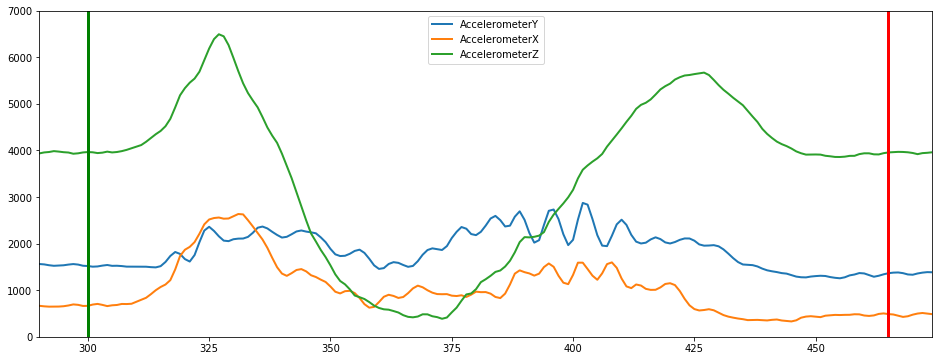

In [20]:
plot_segment(data, segmented_data, segment_id=1, axis=['AccelerometerY', 'AccelerometerX','AccelerometerZ'], ylim=(0,7000))

### Windowing Threshold Algorithm

The windowing  threshold algorithm is a customizable threshold algorithm that allows you to flexibly specify many of the parameters. In technical terms we compute a threshold space use a sliding window on the axis you choose transforming the original timeseries domain into one of the following (standard deviation, absolute sum, sum, variance, absolute average). This is a general algorithm than can be tuned to suit a variety of applications, particularly in cases where events are well separated in time domain. It is different from the General Threshold Algorithm in that as soon as it detects a point above the threshold value, it will create a window of a set size. This is a very simple segmentation algorithm that can be good for detecting events quickly, but is not great at detecting the correct duration of the event. 

In [21]:
dsk.pipeline.reset()
dsk.pipeline.set_input_data('pause_gesture.csv', group_columns=['Subject'])

#Applying windowing thresholding
dsk.pipeline.add_transform('Windowing Threshold Segmentation', params={'column_of_interest': 'AccelerometerZ',
                                                         'window_size':195, 
                                                         'delta':196,
                                                         'vt_threshold':600.0, 
                                                         'threshold_space_width':25,
                                                         'threshold_space':'std',
                                                         'return_segment_index':True
                                               }
                          )


segmented_data, stats = dsk.pipeline.execute()

Label Column must be a string
Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: pause_gesture.csv         		Type: featurefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing Threshold Segmentation 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------


Checking for Results:

Retrieving page 1 of 1.

Results Retrieved.


column AccelerometerZ is not in your dataframe.


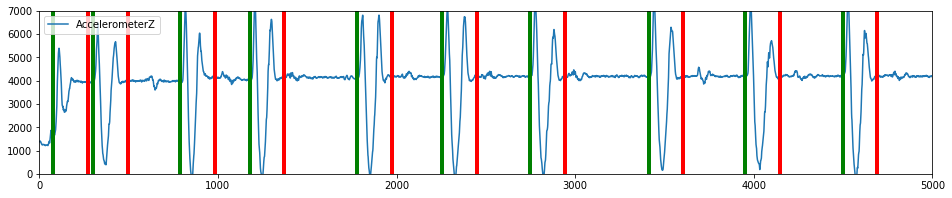

In [22]:
plot_segmented_data_stream(data, segmented_data, 'AccelerometerZ', ylim=(0,7000))